# Training

**The objective is to see how indicators impact the economy and how it reflects on precious metal prices in a monthly view.**

- Metals price data (Silver, Gold, Copper, Palladium, Platinum)

- Inflation

    - Global

- US Consumer Price Index (CPI)

- Interest Rates

    - Chile

    - US

    - China

    - South Africa

    - Canada 

    - Mexico

- Oil Prices

## Load Data

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import lightgbm as lgb
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from sklearn.impute import SimpleImputer

### Metals
**Precious metals impact economy through value, trade, and inflation.**

In [40]:
silver = pd.read_csv('datasets/Finance/Silver Futures Historical Data.csv')
gold = pd.read_csv('datasets/Finance/Gold Futures Historical Data.csv')
copper = pd.read_csv('datasets/Finance/Copper Futures Historical Data.csv')
palladium = pd.read_csv('datasets/Finance/Palladium Futures Historical Data.csv')
platinum = pd.read_csv('datasets/Finance/Platinum Futures Historical Data.csv')
silver.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,10/18/2023,23.038,22.983,23.488,22.845,NaN,0.06%
1,10/17/2023,23.024,22.780,23.180,22.535,48.47K,1.14%
2,10/16/2023,22.765,22.910,22.910,22.635,36.55K,-0.57%
3,10/13/2023,22.895,21.985,22.990,21.960,76.26K,4.26%
4,10/12/2023,21.959,22.205,22.390,21.880,51.30K,-0.79%


In [41]:
print(f"Silver\t\t{silver.shape}")
print(f"Gold \t\t{gold.shape}")
print(f"Copper \t\t{copper.shape}")
print(f"Palladium \t{palladium.shape}")
print(f"Platinum \t{platinum.shape}")

Silver		(2746, 7)
Gold 		(2766, 7)
Copper 		(2754, 7)
Palladium 	(3024, 7)
Platinum 	(3318, 7)


### Consumer Price Index 
**US CPI measures consumer price inflation.**

In [42]:
us_cpi = pd.read_csv('datasets/Finance/us cpi/cpi.csv')
us_cpi.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,2013,230.280,232.166,232.773,232.531,232.945,233.504,233.596,233.877,234.149,233.546,233.069,233.049
1,2014,233.916,234.781,236.293,237.072,237.900,238.343,238.250,237.852,238.031,237.433,236.151,234.812
2,2015,233.707,234.722,236.119,236.599,237.805,238.638,238.654,238.316,237.945,237.838,237.336,236.525
3,2016,236.916,237.111,238.132,239.261,240.229,241.018,240.628,240.849,241.428,241.729,241.353,241.432
4,2017,242.839,243.603,243.801,244.524,244.733,244.955,244.786,245.519,246.819,246.663,246.669,246.524


In [43]:
print("CPI", us_cpi.shape)

CPI (11, 13)


### Interest Rates
**Interest rates influence borrowing, spending, and investment.**

In [44]:
interest_rates = pd.read_csv("datasets/Finance/interestrates/EO_18102023022850125.csv")
interest_rates.head()

,LOCATION,Country,VARIABLE,Variable,FREQUENCY,Frequency,TIME,Time,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
0,CAN,Canada,IRS,Short-term interest rate,Q,Quarterly,2013-Q1,Q1-2013,PC,Percentage,0,Units,NaN,NaN,1.160000,NaN,NaN
1,CAN,Canada,IRS,Short-term interest rate,Q,Quarterly,2013-Q2,Q2-2013,PC,Percentage,0,Units,NaN,NaN,1.160667,NaN,NaN
2,CAN,Canada,IRS,Short-term interest rate,Q,Quarterly,2013-Q3,Q3-2013,PC,Percentage,0,Units,NaN,NaN,1.168424,NaN,NaN
3,CAN,Canada,IRS,Short-term interest rate,Q,Quarterly,2013-Q4,Q4-2013,PC,Percentage,0,Units,NaN,NaN,1.168606,NaN,NaN
4,CAN,Canada,IRS,Short-term interest rate,Q,Quarterly,2014-Q1,Q1-2014,PC,Percentage,0,Units,NaN,NaN,1.170000,NaN,NaN


In [45]:
print("Interest Rates", interest_rates.shape)

Interest Rates (473, 17)


### Crude Oil Prices
**Crude oil prices affect energy costs and global economy.**

In [46]:
crude_oil = pd.read_csv("datasets/Finance/oil/crude-oil-price.csv")
crude_oil.head()

,date,price,percentChange,change
0,1983-03-30T00:00:00,29.27,NaN,NaN
1,1983-04-04T00:00:00,30.63,4.646,1.36
2,1983-05-02T00:00:00,30.25,-1.241,-0.38
3,1983-06-01T00:00:00,31.38,3.736,1.13
4,1983-07-01T00:00:00,32.00,1.976,0.62


In [47]:
print("Crude Oil Prices", crude_oil.shape)

Crude Oil Prices (489, 4)


**Process Dates**

In [48]:
silver['Date'] = pd.to_datetime(silver['Date'])
gold['Date'] = pd.to_datetime(gold['Date'])
copper['Date'] = pd.to_datetime(copper['Date'])
palladium['Date'] = pd.to_datetime(palladium['Date'])
platinum['Date'] = pd.to_datetime(platinum['Date'])

In [49]:
def stringToNumber(data):
    df = data.copy()
    cols = df.columns
    for c in cols:
        if df[c].dtype == 'object':
            df[c] = df[c].str.replace('%', '')  # Remove percentage symbols
            df[c] = df[c].str.replace(',', '')  # Remove thousand separators
            df[c] = df[c].astype(float)  # Convert to float
    return df

silver[['Price', 'Open', 'High', 'Low', 'Change %']] = stringToNumber(silver[['Price', 'Open', 'High', 'Low', 'Change %']])
gold[['Price', 'Open', 'High', 'Low', 'Change %']] = stringToNumber(gold[['Price', 'Open', 'High', 'Low', 'Change %']])
copper[['Price', 'Open', 'High', 'Low', 'Change %']] = stringToNumber(copper[['Price', 'Open', 'High', 'Low', 'Change %']])
palladium[['Price', 'Open', 'High', 'Low', 'Change %']] = stringToNumber(palladium[['Price', 'Open', 'High', 'Low', 'Change %']])
platinum[['Price', 'Open', 'High', 'Low', 'Change %']] = stringToNumber(platinum[['Price', 'Open', 'High', 'Low', 'Change %']])

In [50]:
crude_oil['date'] = pd.to_datetime(crude_oil['date'])

In [51]:
interest_rates['TIME'] = pd.to_datetime(interest_rates['TIME'].str.replace('-', ''))

In [52]:
#us_cpi['Year'] = pd.to_datetime(us_cpi['Year'])

## Clean Data

In [53]:
us_cpi = pd.melt(us_cpi, id_vars=['Year'], var_name='Month', value_name='Price')
us_cpi.head()

,Year,Month,Price
0,2013,Jan,230.280
1,2014,Jan,233.916
2,2015,Jan,233.707
3,2016,Jan,236.916
4,2017,Jan,242.839


In [54]:
us_cpi['Date'] = pd.to_datetime(us_cpi['Year'].astype(str) + '-' + us_cpi['Month'])
us_cpi.head()

,Year,Month,Price,Date
0,2013,Jan,230.280,2013-01-01
1,2014,Jan,233.916,2014-01-01
2,2015,Jan,233.707,2015-01-01
3,2016,Jan,236.916,2016-01-01
4,2017,Jan,242.839,2017-01-01


In [55]:
# Set training window
min_date = silver['Date'].min()
crude_oil = crude_oil[crude_oil['date'] >= min_date]
interest_rates = interest_rates[interest_rates['TIME'] >= min_date]
us_cpi = us_cpi[us_cpi['Date'] >= min_date]

### Plot Values

In [56]:
# Metals date reindex and imputation
plot_df = silver.set_index("Date").resample("M").Price.mean().reset_index()
px.line(plot_df, x='Date', y='Price', title='Silver Price')

In [57]:
# Oil price
plot_df = crude_oil.set_index("date").resample("M").price.mean().reset_index()
px.line(plot_df, x='date', y='price', title='Crude Oil Price')

In [58]:
plot_df = us_cpi.set_index("Date").resample("M").Price.mean().reset_index()
px.line(plot_df, x='Date', y='Price', title='US CPI')

In [59]:
plot_df = interest_rates.set_index("TIME").groupby(['TIME', 'Country', "Time"]).Value.mean().reset_index()
px.line(plot_df, x='TIME', y='Value', color='Country', title='Interest Rates by Country')

### Check Distributions

In [60]:
metals = [silver, gold, copper, palladium, platinum]
metals_name = ['Silver', 'Gold', 'Copper', 'Palladium', 'Platinum']

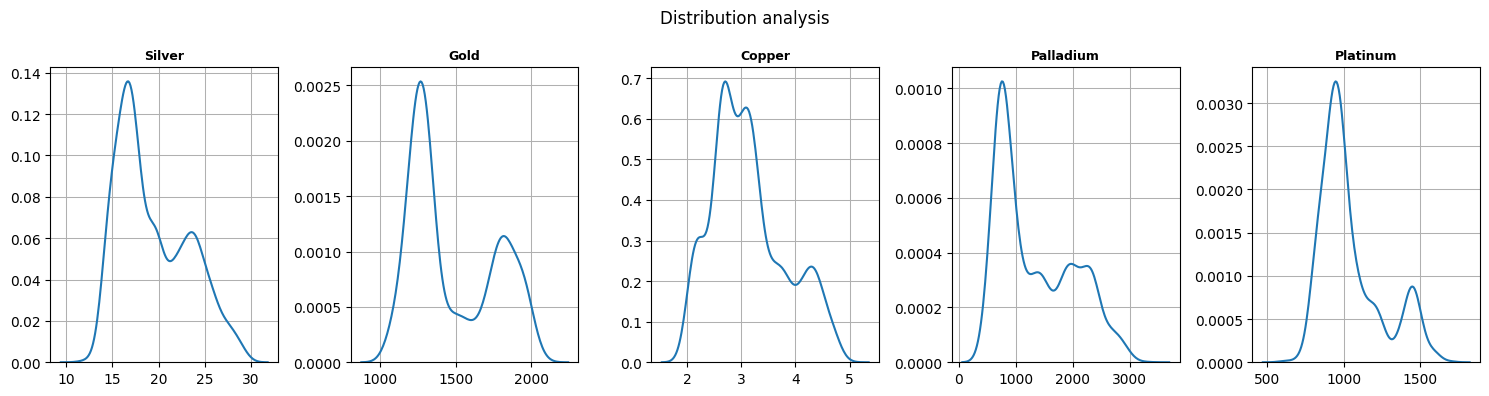

In [61]:
fig, axes = plt.subplots(1, 5, figsize = (15,4))

for i, m in enumerate(metals):
    ax = axes[i]
    sns.kdeplot(data = m, x = 'Price', ax = ax);
    ax.set_title(metals_name[i], fontsize = 9, fontweight= 'bold');
    ax.grid(visible=True, which = 'both', linewidth = 0.75);
    ax.set(xlabel = '', ylabel = '');
plt.suptitle(f"Distribution analysis");
plt.tight_layout();
plt.show();


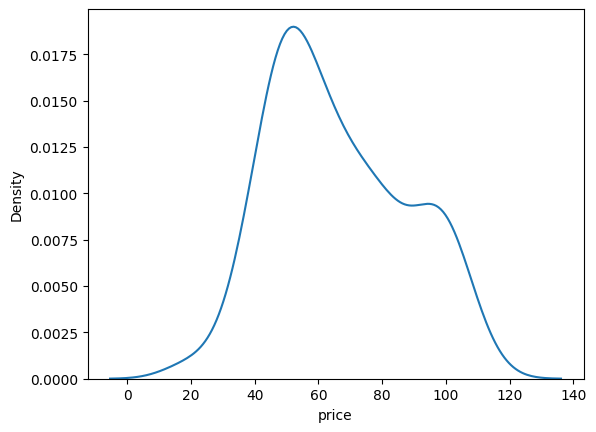

In [62]:
# Crude Oil Price
sns.kdeplot(crude_oil, x='price');

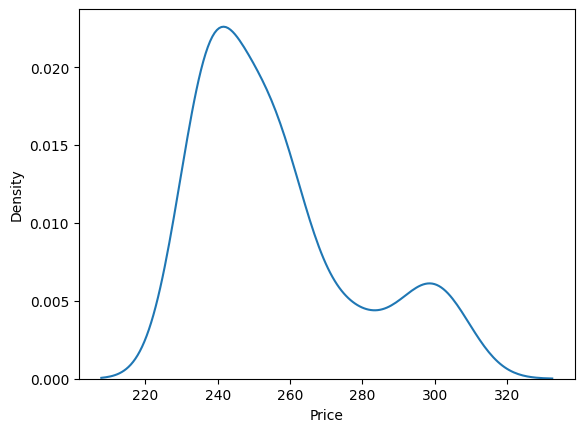

In [63]:
# US CPI
sns.kdeplot(us_cpi, x='Price');

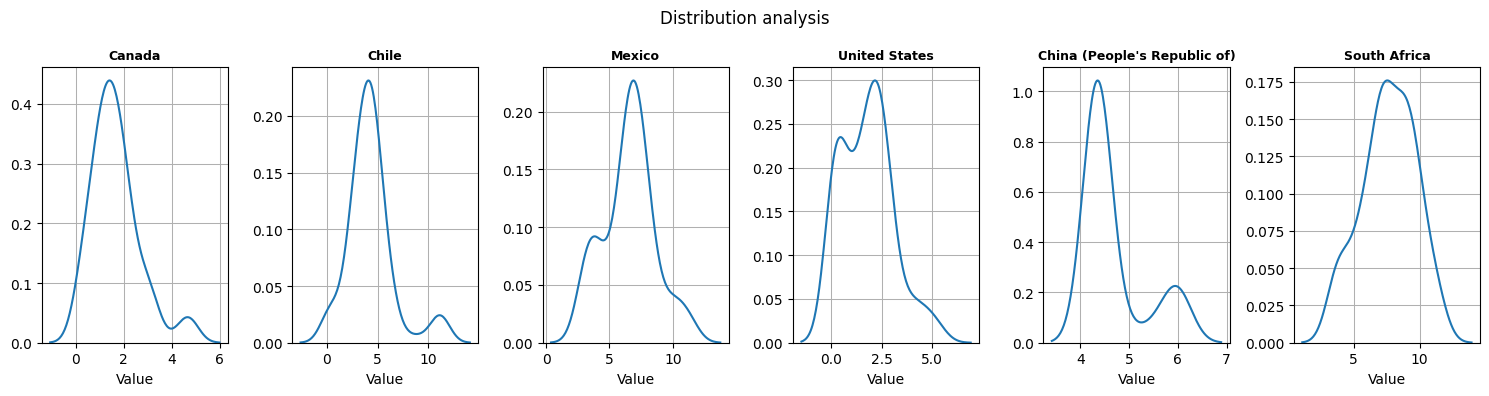

In [64]:
countries = interest_rates['Country'].unique()

fig, axes = plt.subplots(1, len(countries), figsize = (15,4))

for i, c in enumerate(countries):
    ax = axes[i]
    sns.kdeplot(data = interest_rates[interest_rates['Country'] == c], x = 'Value', ax = ax);
    ax.set_title(countries[i], fontsize = 9, fontweight= 'bold');
    ax.grid(visible=True, which = 'both', linewidth = 0.75);
    ax.set(xlabel = 'Value', ylabel = '');
plt.suptitle(f"Distribution analysis");
plt.tight_layout();
plt.show();

### Check null values

In [65]:
print(silver['Price'].isnull().sum())
print(gold['Price'].isnull().sum())
print(copper['Price'].isnull().sum())
print(palladium['Price'].isnull().sum())
print(platinum['Price'].isnull().sum())

0
0
0
0
0


In [66]:
print(us_cpi['Price'].isnull().sum())

3


In [67]:
us_cpi = us_cpi.fillna(method='ffill')

In [68]:
print(interest_rates['Value'].isnull().sum())

0


In [69]:
print(crude_oil['price'].isnull().sum())

0


## Transform data / Normalize time granularity

**Choose desired time granularity and apply to the rest of the data**

In [70]:
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

date_range = pd.date_range(
    min(silver['Date'].min(), platinum['Date'].min()), 
    max(silver['Date'].max(), platinum['Date'].max()), freq=us_bd
)

date_df = pd.DataFrame({'Date': date_range})

print(
    min(silver['Date'].min(), silver['Date'].min()), 
    max(silver['Date'].max(), silver['Date'].max())
)

merged_df_silver = pd.merge(date_df, silver, how='left', on='Date')
merged_df_gold = pd.merge(date_df, gold, how='left', on='Date')
merged_df_copper = pd.merge(date_df, copper, how='left', on='Date')
merged_df_palladium = pd.merge(date_df, palladium, how='left', on='Date')
merged_df_platinum = pd.merge(date_df, platinum, how='left', on='Date')

print("\nMissing values of silver:   ", merged_df_silver['Price'].isnull().sum())
print("Missing values of gold:      ", merged_df_gold['Price'].isnull().sum())
print("Missing values of copper:    ", merged_df_copper['Price'].isnull().sum())
print("Missing values of palladium: ", merged_df_palladium['Price'].isnull().sum())
print("Missing values of platinum:  ", merged_df_platinum['Price'].isnull().sum())

2013-02-18 00:00:00 2023-10-18 00:00:00

Missing values of silver:    26
Missing values of gold:       10
Missing values of copper:     7
Missing values of palladium:  8
Missing values of platinum:   8


In [71]:
merged_df_silver.drop(columns=['Open', 'High', 'Low', 'Vol.', 'Change %'], inplace=True)
merged_df_gold.drop(columns=['Open', 'High', 'Low', 'Vol.', 'Change %'], inplace=True)
merged_df_copper.drop(columns=['Open', 'High', 'Low', 'Vol.', 'Change %'], inplace=True)
merged_df_palladium.drop(columns=['Open', 'High', 'Low', 'Vol.', 'Change %'], inplace=True)
merged_df_platinum.drop(columns=['Open', 'High', 'Low', 'Vol.', 'Change %'], inplace=True)

In [72]:
imputer = SimpleImputer(strategy='mean')

columns = merged_df_silver.columns[1:]

imputed_df_silver = merged_df_silver.copy()
imputed_df_gold = merged_df_gold.copy()
imputed_df_copper = merged_df_copper.copy()
imputed_df_palladium = merged_df_palladium.copy()
imputed_df_platinum = merged_df_platinum.copy()

for c in columns:
    imputed_df_silver[c] = imputed_df_silver[c].interpolate(method='linear')
    imputed_df_gold[c] = imputed_df_gold[c].interpolate(method='linear')
    imputed_df_copper[c] = imputed_df_copper[c].interpolate(method='linear')
    imputed_df_palladium[c] = imputed_df_palladium[c].interpolate(method='linear')
    imputed_df_platinum[c] = imputed_df_platinum[c].interpolate(method='linear')


print("\nMissing values of silver:   ", imputed_df_silver['Price'].isnull().sum())
print("Missing values of gold:      ", imputed_df_gold['Price'].isnull().sum())
print("Missing values of copper:    ", imputed_df_copper['Price'].isnull().sum())
print("Missing values of palladium: ", imputed_df_palladium['Price'].isnull().sum())
print("Missing values of platinum:  ", imputed_df_platinum['Price'].isnull().sum())


Missing values of silver:    0
Missing values of gold:       0
Missing values of copper:     0
Missing values of palladium:  0
Missing values of platinum:   0


In [73]:
imputed_df_silver.shape

(2675, 2)

**Interest Rates**

In [74]:
interest_rates.columns

Index(['LOCATION', 'Country', 'VARIABLE', 'Variable', 'FREQUENCY', 'Frequency',
       'TIME', 'Time', 'Unit Code', 'Unit', 'PowerCode Code', 'PowerCode',
       'Reference Period Code', 'Reference Period', 'Value', 'Flag Codes',
       'Flags'],
      dtype='object')

In [75]:
interest_rates.rename(columns={'TIME': 'Date', 'Value': 'Interest', 'VARIABLE': 'Interest_Type'}, inplace=True)
interest_rates.drop(columns=['LOCATION', 'FREQUENCY', 'Variable',
       'Frequency', 'Time', 'Unit Code', 'Unit', 'PowerCode Code',
       'PowerCode', 'Reference Period Code', 'Reference Period',
       'Flag Codes', 'Flags'], inplace=True)
interest_rates = interest_rates.pivot(index=['Country', 'Date'], columns='Interest_Type', values='Interest')
interest_rates.reset_index(inplace=True)
interest_rates.head()

Interest_Type,Country,Date,IRL,IRS
0,Canada,2013-04-01,1.964985,1.160667
1,Canada,2013-07-01,2.582537,1.168424
2,Canada,2013-10-01,2.583394,1.168606
3,Canada,2014-01-01,2.469459,1.170000
4,Canada,2014-04-01,2.352857,1.173968


In [76]:
interest_rates = interest_rates.pivot(index='Date', columns='Country', values=['IRL', 'IRS'])
interest_rates.columns = [f'{col[0]}_{col[1]}' for col in interest_rates.columns]
interest_rates.reset_index(inplace=True)
interest_rates.head()

,Date,IRL_Canada,IRL_Chile,IRL_China (People's Republic of),IRL_Mexico,IRL_South Africa,IRL_United States,IRS_Canada,IRS_Chile,IRS_China (People's Republic of),IRS_Mexico,IRS_South Africa,IRS_United States
0,2013-04-01,1.964985,5.241193,NaN,5.280000,7.284470,1.996667,1.160667,5.165688,6.0,3.816667,5.091102,0.196667
1,2013-07-01,2.582537,5.276933,NaN,6.518028,8.168377,2.710000,1.168424,5.294840,6.0,3.820000,5.091228,0.123333
2,2013-10-01,2.583394,5.087689,NaN,6.582194,8.115512,2.746667,1.168606,4.862149,6.0,3.453333,5.083428,0.126667
3,2014-01-01,2.469459,5.025218,NaN,6.730318,8.530106,2.763333,1.170000,4.404972,6.0,3.363333,5.504828,0.123333
4,2014-04-01,2.352857,4.910148,NaN,6.461151,8.302088,2.623333,1.173968,4.008386,6.0,3.290000,5.753463,0.113333


In [77]:
# Visualize Interest Rates
melted_df = pd.melt(interest_rates, id_vars=['Date'], var_name='Country', value_name='Value')
melted_df['Date'] = pd.to_datetime(melted_df['Date'])
melted_df = melted_df.sort_values(['Date', 'Country']).reset_index(drop=True)
px.line(melted_df, x='Date', y='Value', color='Country')

In [78]:
# Merge by year and month
date_df['YearMonth'] = date_df['Date'].dt.to_period('M')
interest_rates['YearMonth'] = interest_rates['Date'].dt.to_period('M')
merged_df = pd.merge(date_df, interest_rates, on='YearMonth', how='left')
merged_df.drop(columns=['YearMonth', 'Date_y'], inplace=True)
merged_df.rename(columns={'Date_x': 'Date'}, inplace=True)

In [79]:
print(
    min(interest_rates['Date'].min(), interest_rates['Date'].min()), 
    max(interest_rates['Date'].max(), interest_rates['Date'].max())
)

merged_df_interest_rates = pd.merge(date_df, interest_rates, how='left', on='Date')
print("\nMissing values of interest_rates:   ", merged_df_interest_rates['Interest'].isnull().sum())

2013-04-01 00:00:00 2023-07-01 00:00:00


KeyError: 'Interest'

**Evaluate distributions again**

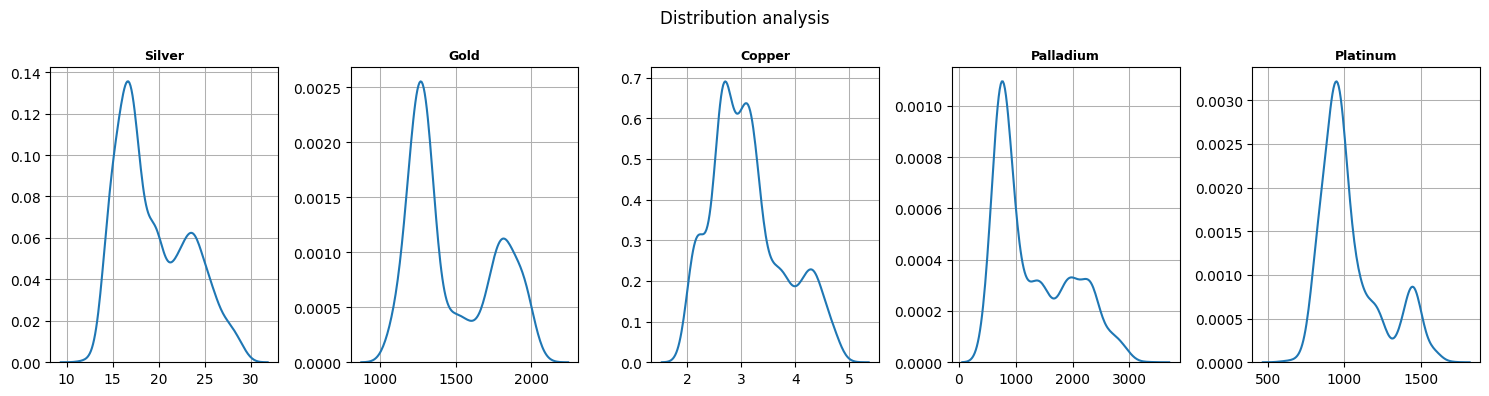

In [ ]:
metals = [imputed_df_silver, imputed_df_gold, imputed_df_copper, imputed_df_palladium, imputed_df_platinum]
metals_name = ['Silver', 'Gold', 'Copper', 'Palladium', 'Platinum']
fig, axes = plt.subplots(1, 5, figsize = (15,4))

for i, m in enumerate(metals):
    ax = axes[i]
    sns.kdeplot(data = m, x = 'Price', ax = ax);
    ax.set_title(metals_name[i], fontsize = 9, fontweight= 'bold');
    ax.grid(visible=True, which = 'both', linewidth = 0.75);
    ax.set(xlabel = '', ylabel = '');
plt.suptitle(f"Distribution analysis");
plt.tight_layout();
plt.show();


## First experiment / Baseline